# Active Learning through Dataset Reduction: Conclusion

**Author**: Benjamin Urben<br>
**Email**: burben@student.ethz.ch / benjamin.urben@hotmail.ch<br>
**Context**: Master Thesis on "Use of Machine Learning in the Design and Analysis for Steel Connections"<br>
**Institution**: ETH Zürich, Institute of Structural Engineering (IBK)

**Description**:

Simulations to establish best learning function, by reducing the dataset and strategically incrementing it, evaluating the DNN alongside.

**Dependencies**: 
- `DNN.py`
- `AL.py`
- `Datareader.py`
- `Settings.py`
- `Plot_Functions.py`

## Setup

In [31]:
import os
import importlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import copy

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from scipy.stats import norm
from scipy import stats

import torch
import torch.nn as nn
import torch.optim as optim

from Settings import Directory, Plotting_Parameters

import DataReader
importlib.reload(DataReader)
from DataReader import DataReader

import DNN
importlib.reload(DNN)
from DNN import DNN

import ActiveLearning
importlib.reload(ActiveLearning)
from ActiveLearning import ActiveLearning as AL

import warnings
warnings.filterwarnings('ignore')

## Directory

In [32]:
directory = Directory()
plot_params = Plotting_Parameters()

model_name = "DNN_Model_Full"

DATA_FILE = r"Data\Knee_Connection_Output_red.csv"
MODEL_SAVE_PATH = os.path.join("Saved Models", model_name)
MODEL_SAVE_FILE = os.path.join(MODEL_SAVE_PATH, f"{model_name}.pth")

Root Directory set to:  c:\Users\benja\OneDrive\Desktop\Masterarbeit\Code\10_Neural_Networks


## Load Model and Data

In [33]:
model_benchmark = torch.load(MODEL_SAVE_FILE)

for line in model_benchmark.config:
    print(line+":", model_benchmark.config[line])

batch_size: 256
epochs: 1000
learning_rate: 0.01
test_size: 0.1
val_size: 0.1
print_logs: True
dropout_prob: 0.05
num_layers: 3
neurons_per_layer: [64, 32, 16]
use_batch_norm: False
seed: 42


In [34]:
datareader = DataReader()
df_full = datareader.load(model_benchmark.data['data_file_name'])
df = df_full.iloc[model_benchmark.data['data_indeces']]

print('Data Shape:', df.shape)

Root Directory set to:  c:\Users\benja\OneDrive\Desktop\Masterarbeit\Code\10_Neural_Networks
Knee_Connection_Output_red.csv
Knee_parallel_I_Off0_Output_red_Q1.xlsx
Knee_parallel_I_Output_Q1.xlsx
Knee_perpendicular_n.stiff_Off0_Output_red_Q1.xlsx
Knee_perpendicular_n.stiff_Output_red_Q1.xlsx
Knee_widener_I_Output_Off0_red_Q1.xlsx
Knee_widener_I_Output_red_Q1.xlsx
Knee_Connection_Output_red.csv: (714385, 53)
Data Shape: (714385, 53)


## Active Learning

### Adapt Benchmark Configuration

In [ ]:
model = DNN()

# Copy the model parameters from the benchmark model to the test model
for line in model_benchmark.config:
    model.config[line] = model_benchmark.config[line]

for line in model_benchmark.data:
    model.data[line] = model_benchmark.data[line]

model.features = model_benchmark.features
model.target = model_benchmark.target

# Adjust epochs and learning rate
model.config['epochs'] = 100
model.config['learning_rate'] = 0.01
model.config['dropout_prob'] = 0.0

# Load data
df = df_full.iloc[model_benchmark.data['data_indeces']]

# Prepare test model
model.prepare_data(df)
model.build()

Number of training samples: 571508
Number of validation samples: 71438
Number of testing samples: 71439


### Active Learning Method

In [36]:
def minimize_MCD_mean_and_uncertainty(model,df_remaining,alpha=0.5):
    X_remaining = df_remaining[model.features].to_numpy()
    X_remaining_std = model.scaler_x.transform(X_remaining)
    X_tensor = torch.tensor(X_remaining_std, dtype=torch.float32)

    y_remaining = df_remaining[model.target].to_numpy()

    mean_pred, std_pred, _ = model.mc_dropout_uncertainty(X_tensor, num_samples=100)

    cv_pred = std_pred / mean_pred

    # Take absolute value and -1 to be able to tell which sample deviates the most
    pred_truth_ratio = np.abs(mean_pred/y_remaining-1)
    error = np.abs(mean_pred - y_remaining)

    # Give each sample a rank based on how close it is to ideal prediction (1.0) (Rank 1 is best sample)
    sorted_indices_mean = np.argsort(pred_truth_ratio.flatten())
    ranks_mean = np.empty_like(sorted_indices_mean)
    ranks_mean[sorted_indices_mean] = np.arange(len(sorted_indices_mean))

    # Give each sample a rank based on how uncertain the model is (Rank 1 is best sample)
    sorted_indices_cv = np.argsort(cv_pred.flatten())
    ranks_cv = np.empty_like(sorted_indices_cv)
    ranks_cv[sorted_indices_cv] = np.arange(len(sorted_indices_cv))

    # For each sample add the ranks of the two metrics
    score = alpha*ranks_mean + (1-alpha)*ranks_cv

    return score, mean_pred, std_pred, cv_pred, y_remaining, ranks_cv, ranks_mean, error, pred_truth_ratio

#### Method Visualization

In [37]:
df_test = df.iloc[model_benchmark.data['test_data']]
score, mean_pred, std_pred, cv_pred, y_truth, ranks_cv, ranks_mean, error, pred_truth_ratio = minimize_MCD_mean_and_uncertainty(model_benchmark,df_test,alpha=0.5)

Standard Deviation of MCD for each data point.

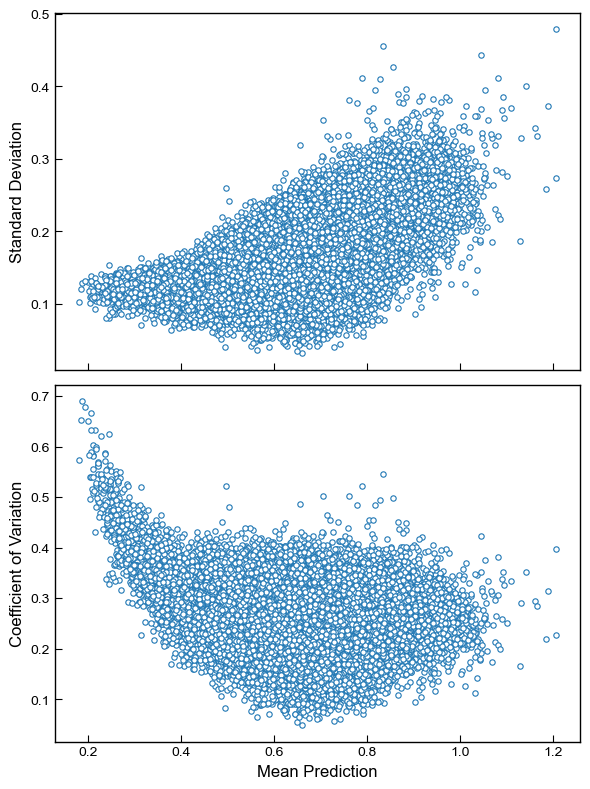

In [38]:
fig, axs = plt.subplots(2,1,figsize=(6,8),sharex=True)

axs[0].scatter(mean_pred, std_pred, 
               s = 15, color='white', 
               edgecolors=plot_params.morecolors[0], linewidth=0.8)
axs[1].scatter(mean_pred, cv_pred, 
               s = 15, color='white',
               edgecolors=plot_params.morecolors[0], linewidth=0.8)

axs[0].set_ylabel("Standard Deviation")
axs[1].set_ylabel("Coefficient of Variation")

plt.xlabel("Mean Prediction")

plt.tight_layout()
plt.show()

**Score** calculation based on MCD mean and MCD uncertainty rankings.

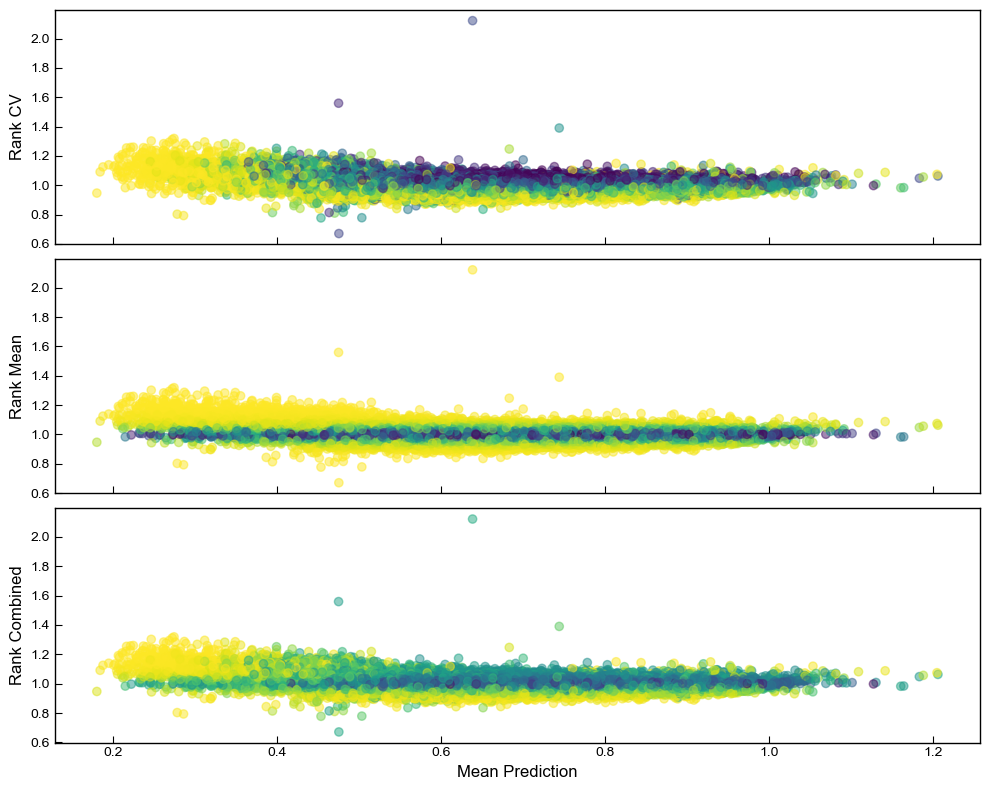

In [39]:
fig, axs = plt.subplots(3,1,figsize=(10,8), sharex=True)

axs[0].scatter(mean_pred, mean_pred / y_truth, c=ranks_cv, alpha=0.5)
axs[1].scatter(mean_pred, mean_pred / y_truth, c=ranks_mean, alpha=0.5)
axs[2].scatter(mean_pred, mean_pred / y_truth, c=score, alpha=0.5)

axs[0].set_ylabel("Rank CV")
axs[1].set_ylabel("Rank Mean")
axs[2].set_ylabel("Rank Combined")

plt.xlabel('Mean Prediction')

plt.tight_layout()
plt.show()

**Score** calculation based on Coefficient of variation of MCD and absolute prediction error.

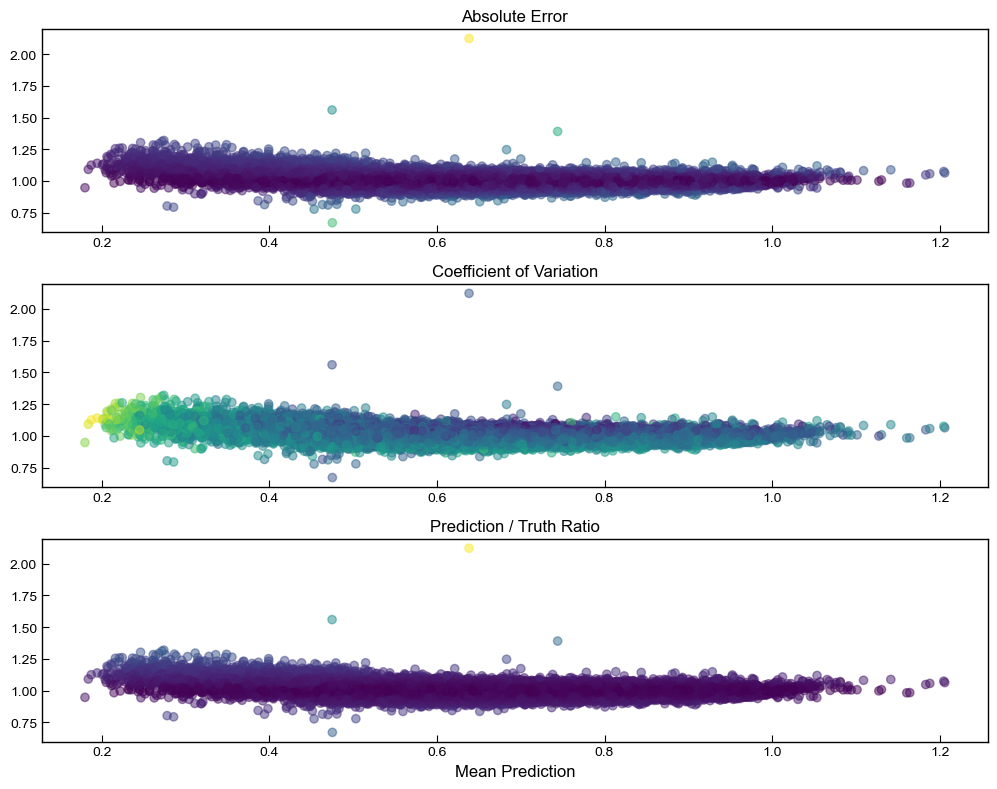

In [40]:
fig, axs = plt.subplots(3,1,figsize=(10,8))

axs[0].scatter(mean_pred, mean_pred / y_truth, c=error, alpha=0.5)
axs[1].scatter(mean_pred, mean_pred / y_truth, c=cv_pred, alpha=0.5)
axs[2].scatter(mean_pred, mean_pred / y_truth, c=pred_truth_ratio, alpha=0.5)

axs[0].set_title("Absolute Error")
axs[1].set_title("Coefficient of Variation")
axs[2].set_title("Prediction / Truth Ratio")

plt.xlabel('Mean Prediction')

plt.tight_layout()
plt.show()

#### Score Calculation

In [41]:
scaler = StandardScaler()
score_new = scaler.fit_transform(cv_pred) + scaler.fit_transform(error)

Number of samples above threshold: 273 (0.38%)


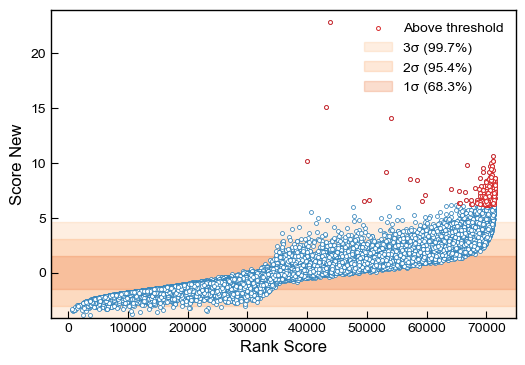

In [43]:
mu = np.mean(score_new)
sigma = np.std(score_new)

#threshold = np.percentile(score_new, 95)
threshold = mu + 4*sigma
indices = np.where(score_new > threshold)[0]

fig, ax = plt.subplots(figsize=(6,4))

plt.scatter(score, score_new, 
            s = 8.0,
            edgecolors=plot_params.colors[0], 
            linewidth=0.5, color='white')

plt.scatter(score[indices], score_new[indices], 
            s = 8.0, 
            edgecolors=plot_params.colors[3],
            linewidth=0.7,
            color='white',
            label='Above threshold')

# 3rd standard deviation (μ ± 3σ)
ax.axhspan(mu - 3*sigma, mu + 3*sigma, alpha=0.2, color=plt.cm.tab20c.colors[6], 
           label='3σ (99.7%)', zorder=0)

# 2nd standard deviation (μ ± 2σ)
ax.axhspan(mu - 2*sigma, mu + 2*sigma, alpha=0.2, color=plt.cm.tab20c.colors[5], 
           label='2σ (95.4%)', zorder=0)

# 1st standard deviation (μ ± 1σ)
ax.axhspan(mu - 1*sigma, mu + 1*sigma, alpha=0.2, color=plt.cm.tab20c.colors[4], 
           label='1σ (68.3%)', zorder=0)

print(f"Number of samples above threshold: {len(indices)} ({len(indices)/len(score)*100:.2f}%)")

plt.ylim([min(score_new)*1.05, max(score_new)*1.05])
plt.xlabel("Rank Score")
plt.ylabel("Score New")
plt.legend()

plt.show()

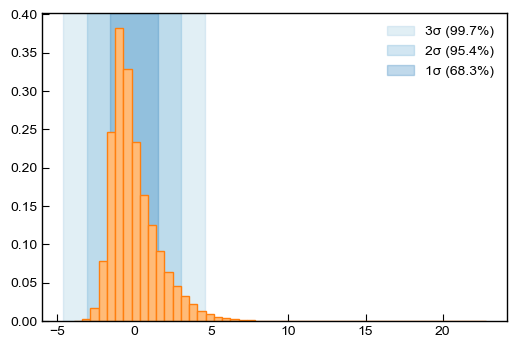

In [44]:
fig, ax = plt.subplots(figsize=(6,4))

counts, bins, _ = plt.hist(score_new, bins=50, 
             density=True, 
             facecolor=plot_params.morecolors[3], 
             edgecolor=plot_params.morecolors[2],
             zorder=2
)

mu = np.mean(score_new)
sigma = np.std(score_new)

# 3rd standard deviation (μ ± 3σ)
ax.axvspan(mu - 3*sigma, mu + 3*sigma, alpha=0.3, color=plt.cm.tab20c.colors[2], 
           label='3σ (99.7%)', zorder=0)

# 2nd standard deviation (μ ± 2σ)
ax.axvspan(mu - 2*sigma, mu + 2*sigma, alpha=0.3, color=plt.cm.tab20c.colors[1], 
           label='2σ (95.4%)', zorder=0)

# 1st standard deviation (μ ± 1σ)
ax.axvspan(mu - 1*sigma, mu + 1*sigma, alpha=0.3, color=plt.cm.tab20c.colors[0], 
           label='1σ (68.3%)', zorder=0)

plt.legend()
plt.show()

### Selection Function

In [ ]:
def select(model,df_remaining,alpha=0.5,select_beyond=2.0, dropout_prob=0.1):
    X_remaining = df_remaining[model.features].to_numpy()
    X_remaining_std = model.scaler_x.transform(X_remaining)
    X_tensor = torch.tensor(X_remaining_std, dtype=torch.float32)

    y_remaining = df_remaining[model.target].to_numpy()

    model.dropout.p = dropout_prob
    mean_pred, std_pred, _ = model.mc_dropout_uncertainty(X_tensor, num_samples=100)
    model.dropout.p = model.config['dropout_prob']

    cv_pred = std_pred / mean_pred
    error = np.abs(mean_pred - y_remaining)

    scaler = StandardScaler()
    score = alpha*scaler.fit_transform(cv_pred) + (1-alpha)*scaler.fit_transform(error)

    mu = np.mean(score)
    sigma = np.std(score)

    threshold = mu + select_beyond*sigma
    indices = np.where(score > threshold)[0]

    print(f"{len(indices)} selected!")

    if len(indices) == 0:
        print("No samples above threshold")
        return None, None
        
    #df_remaining['score'] = score

    #df_new = df_remaining.nlargest(batch_size, 'score').drop(columns=['score'])
    #df_remaining = df_remaining.drop(df_new.index)

    df_new = df_remaining.iloc[indices]
    df_remaining = df_remaining.drop(df_new.index)

    return df_new, df_remaining

### Active Learning Process

In [47]:
max_iterations = 100
initial_samples = 10_000
initial_epochs = 200
select_beyond_z = 4

In [ ]:
performance = {'data_ratio': [], 'data_indeces': [], 'epoch': [],
               'MSE': [], 'RMSE': [], 'MAE': [], 'R2': [], 'MCDMS': [], 'MCDUS': []}

df_train = df.sample(n=initial_samples)
df_remaining = df.drop(df_train.index)

model.config['print_logs'] = False
model.config['epochs'] = initial_epochs

model.prepare_data(df_train)
model.build()
model.train()

# Initial metrics
metrics = model.get_metrics()

# Update log
performance['data_ratio'].append(len(df_train) / len(df))
performance['data_indeces'].append(df_train.index.tolist())  
performance['epoch'].append(initial_epochs)  

for metric in metrics:
    performance[metric].append(metrics[metric])

print(f"Initial R² Score: {metrics['R2']}")

for i in range(max_iterations+1):

    print(f"Iteration {i + 1}: Training with {len(df_train)} samples")

    df_new, df_remaining = select(model, df_remaining, select_beyond=select_beyond_z)
    if df_new is None:
        print("No new samples selected. Stopping.")
        break

    df_train = pd.concat([df_train, df_new])

    # Fine Tune Epoch proportional to the number added samples
    fine_tune_epochs = int(len(df_new)/10)
    print(f"Fine-tuning for {fine_tune_epochs} epochs")

    model.fine_tune(df_new, epochs=fine_tune_epochs)

    # Evaluate model performance.
    metrics = model.get_metrics()

    # Update log
    performance['data_ratio'].append(len(df_train) / len(df))
    performance['data_indeces'].append(df_train.index.tolist()) 
    performance['epoch'].append(fine_tune_epochs+performance['epoch'][-1])
    for metric in metrics:
        performance[metric].append(metrics[metric])
    print(f"    R² Score: {metrics['R2']}")

Initial R² Score: 0.95237647742033
Iteration 1: Training with 10000 samples
2771 selected!
Fine-tuning for 277 epochs
    R² Score: 0.9514421410858631
Iteration 2: Training with 12771 samples
3522 selected!
Fine-tuning for 352 epochs
    R² Score: 0.9716405719518661
Iteration 3: Training with 16293 samples
2322 selected!
Fine-tuning for 232 epochs
    R² Score: 0.9672977738082409
Iteration 4: Training with 18615 samples
2024 selected!
Fine-tuning for 202 epochs
    R² Score: 0.9774943627417088
Iteration 5: Training with 20639 samples
2195 selected!
Fine-tuning for 219 epochs
    R² Score: 0.9821340851485729
Iteration 6: Training with 22834 samples
1774 selected!
Fine-tuning for 177 epochs
    R² Score: 0.9824220947921276
Iteration 7: Training with 24608 samples
1514 selected!
Fine-tuning for 151 epochs
    R² Score: 0.9865531958639622
Iteration 8: Training with 26122 samples
1753 selected!
Fine-tuning for 175 epochs
    R² Score: 0.9800118338316679
Iteration 9: Training with 27875 samp

KeyboardInterrupt: 

## Analyse Performance

Chosen data from **Active Learning**:

In [59]:
df_reduced = df_full.iloc[performance['data_indeces'][-1]]

#### Train and Validation Loss

Text(0, 0.5, 'Loss')

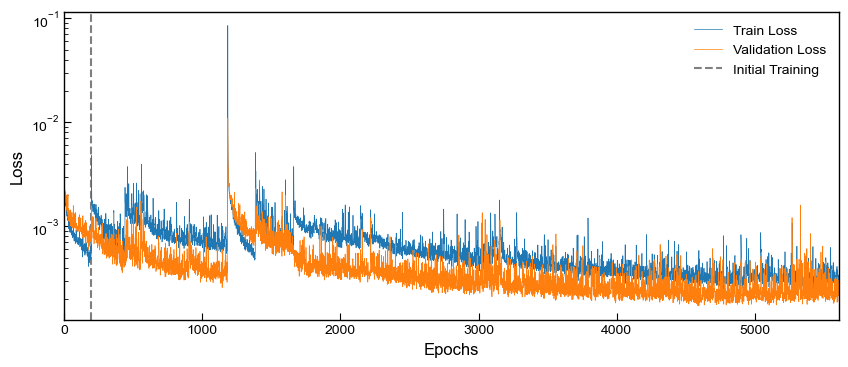

In [65]:
fig, ax = plt.subplots(figsize=(10,4))

plt.plot(model.train_losses['total'],
            c=plot_params.colors[0],
            linewidth=0.5,
         label='Train Loss')
plt.plot(model.val_losses['total'],
         c=plot_params.colors[1],
         linewidth=0.5,
         label='Validation Loss')

plt.axvline(initial_epochs, color='black', 
            linestyle='--', label='Initial Training',
            zorder=0, alpha=0.5)

plt.yscale('log')
plt.xlim([0, len(model.train_losses['total'])])
plt.ylim([0, None])

plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')

#### Performance Metrics

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


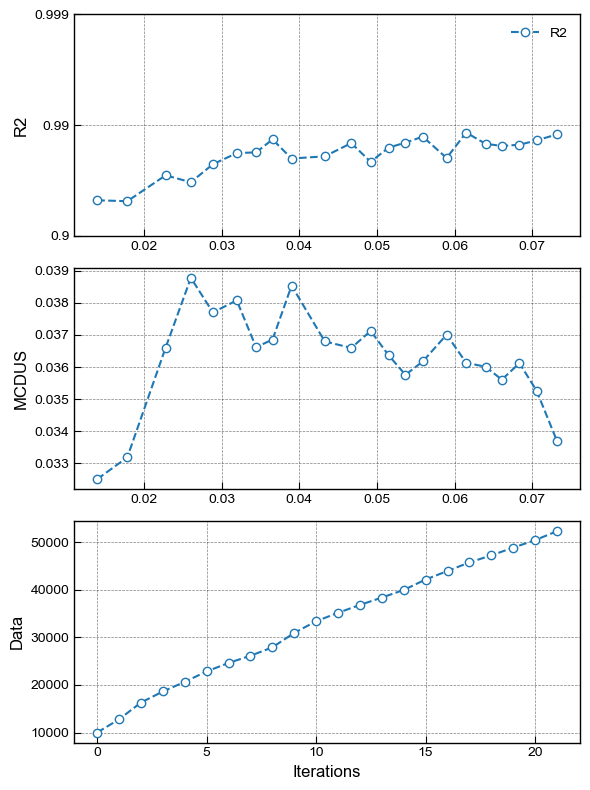

In [61]:
fig, axs = plt.subplots(3,1, figsize=(6,8))

R2 = np.array(performance['R2'])
R2_log = -np.log10(np.array(1-R2))

axs[0].plot(performance['data_ratio'], R2_log,
            color=plot_params.colors[0], 
            marker='o',
            markersize=6,
            linestyle='--',
            markerfacecolor='white',
            markeredgecolor=plot_params.colors[0],
            label='R2')

axs[0].set_ylabel('R2')
axs[0].set_yticks(range(1, 3 + 1), [f"0.{'9' * i}" for i in range(1, 4)])
axs[0].legend()
axs[0].grid(True, which='major', color='k', linestyle='--', linewidth=0.5, alpha=0.5)

axs[1].plot(performance['data_ratio'], performance['MCDUS'],
            color=plot_params.colors[0], 
            marker='o',
            markersize=6,
            linestyle='--',
            markerfacecolor='white',
            markeredgecolor=plot_params.colors[0])

axs[1].set_ylabel('MCDUS')
axs[1].legend()
axs[1].grid(True, which='major', color='k', linestyle='--', linewidth=0.5, alpha=0.5)

axs[2].plot(np.arange(len(performance['data_indeces'])), [len(data) for data in performance['data_indeces']],
            color=plot_params.colors[0], 
            marker='o',
            markersize=6,
            linestyle='--',
            markerfacecolor='white',
            markeredgecolor=plot_params.colors[0])

axs[2].set_ylabel('Data')
axs[2].set_xlabel('Iterations')
axs[2].legend()
axs[2].grid(True, which='major', color='k', linestyle='--', linewidth=0.5, alpha=0.5)

plt.tight_layout()
plt.show()

## Analyse Model Performance

In [62]:
from Plot_Functions import plot_MV_interaction

0 profiles found with the same fixed features


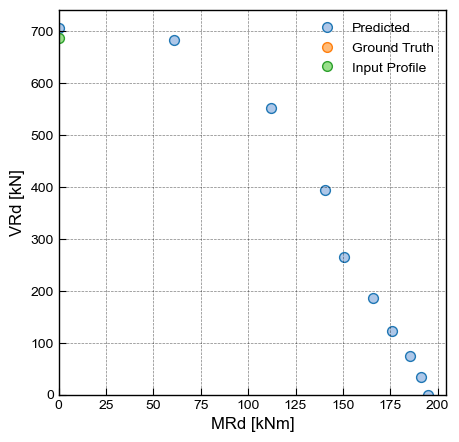

2 profiles found with the same fixed features


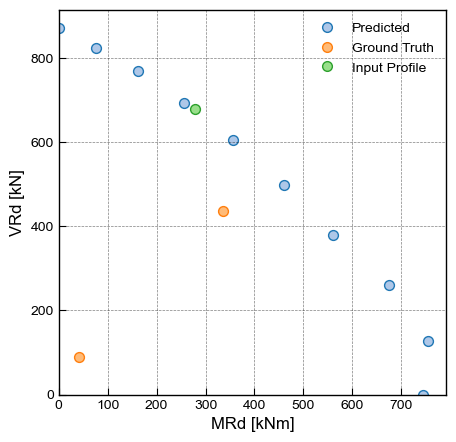

0 profiles found with the same fixed features


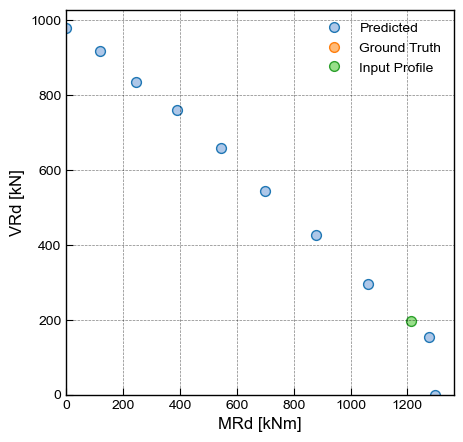

0 profiles found with the same fixed features


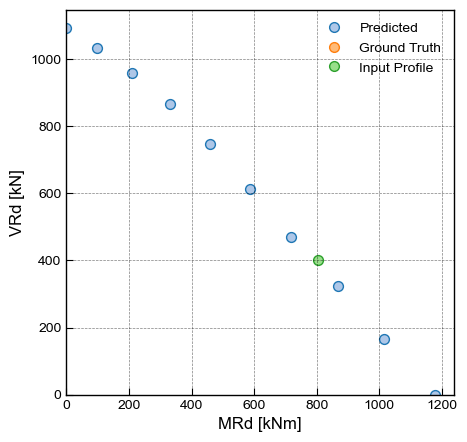

1 profiles found with the same fixed features


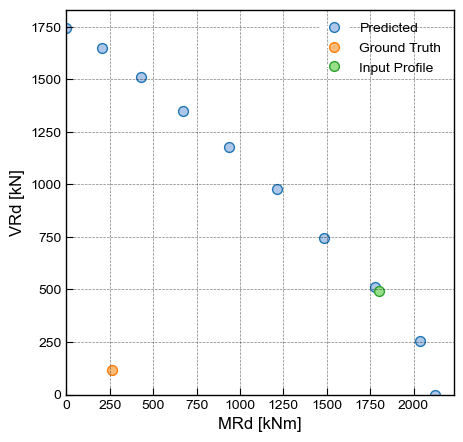

0 profiles found with the same fixed features


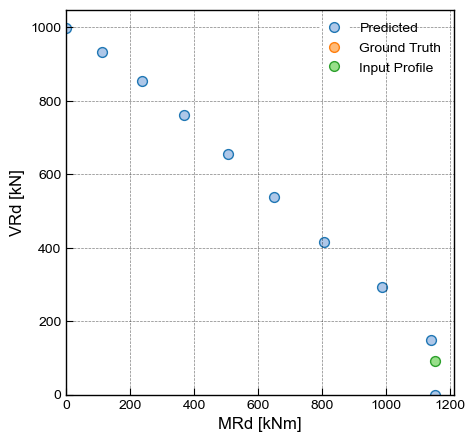

2 profiles found with the same fixed features


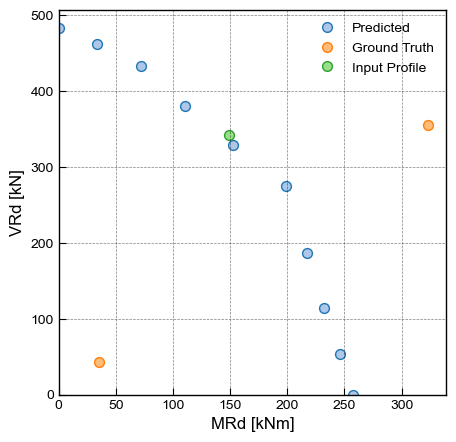

0 profiles found with the same fixed features


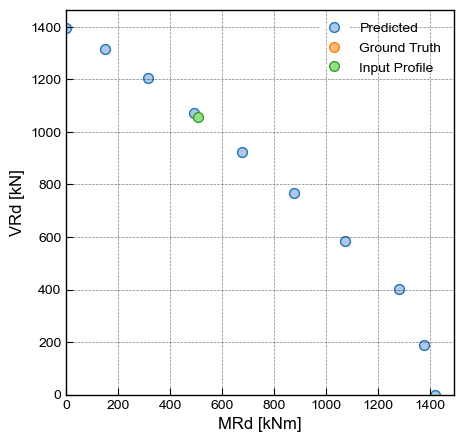

0 profiles found with the same fixed features


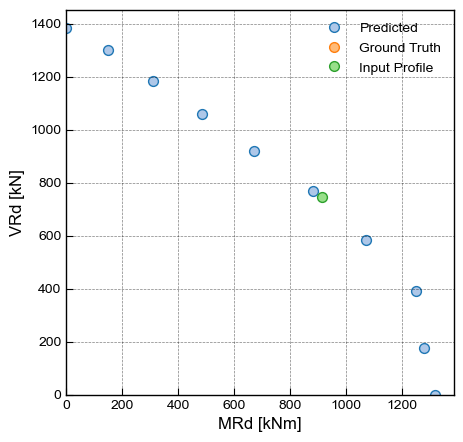

0 profiles found with the same fixed features


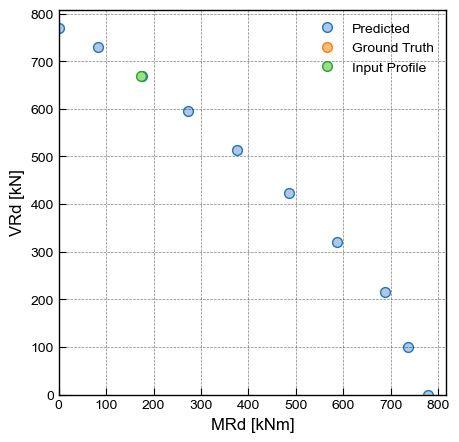

In [78]:
x_profile = df.iloc[0]
df_model = df_full.iloc[model.data['data_indeces']]

random_indices = np.random.choice(model.data['data_indeces'], 10, replace=False)

for i in range(10):
    x_profile = df_model.iloc[random_indices[i]]
    plot_MV_interaction(x_profile,model,df_model)